In [1]:
import torch
import math

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import ViTForImageClassification, AutoProcessor
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
 class LogitsOnlyWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs).logits

In [6]:
raw_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=1000)
# raw_model.load_state_dict(
#     torch.load("_saved_models/google_vit_patch16_img224_bsz128_lr0.0001_epoch5.pt")["model_state_dict"]
# )
processor = AutoProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
raw_model = LogitsOnlyWrapper(raw_model)
raw_model.eval();

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from PIL import Image

x = Image.open('/shared_data0/weiqiuy/datasets/imagenet/train/n01440764/n01440764_18.JPEG')
inputs = torch.tensor(processor(x)['pixel_values'])
inputs.shape

/tmp/ipykernel_3924/2648143103.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  inputs = torch.tensor(processor(x)['pixel_values'])


torch.Size([1, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


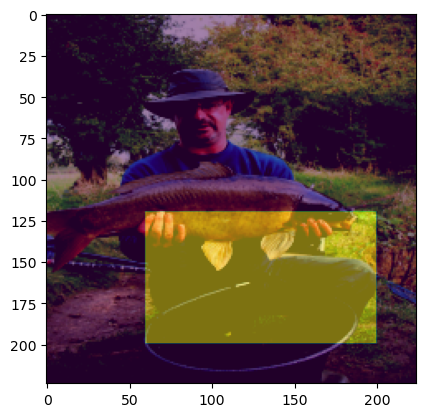

In [8]:
inputs_alpha = torch.zeros_like(inputs) # < 0.1
inputs_alpha[:,:,120:200,60:200] = 1

import matplotlib.pyplot as plt

plt.imshow(inputs[0].permute(1,2,0).cpu())
plt.imshow(inputs_alpha[0][0].cpu(), alpha=0.5)

In [98]:
class MaskedClassifier(nn.Module):
    def __init__(self, base_classfier): #, image_shape, mask_size):
        super().__init__()
        self.base_classifier = base_classfier
        # self.image_shape = image_shape
        # self.mask_size = mask_size
        
    def forward(self, x, alpha):
        '''
        x: (bsz, 3, 224, 224)
        alpha: (bsz, grid_sz, grid_sz)
        '''
        if x.ndim == 3:
            x = x.unsqueeze(0)
        assert x.ndim == 4
        if alpha.ndim == 2:
            alpha = alpha.unsqueeze(0)
        assert alpha.ndim == 3
        assert x.size(0) == alpha.size(0)
        bsz, grid_sz, grid_sz_ = alpha.shape
        patch_sz = x.shape[2] // grid_sz
        # assert
        alpha_big = F.interpolate(alpha.view(bsz,1,grid_sz,grid_sz).float(), scale_factor=(patch_sz,patch_sz)).round().float()
        masked_x = x * alpha_big # (bsz, 3, 224, 224)
        return self.base_classifier(masked_x)
    

In [99]:
masked_model = MaskedClassifier(raw_model)

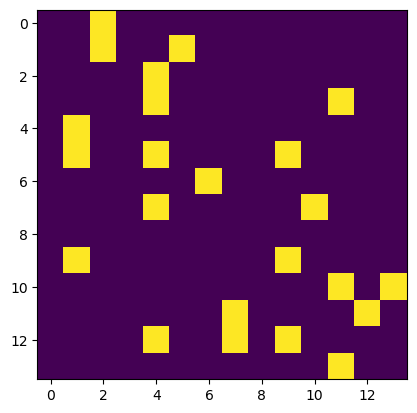

In [100]:
alpha = (torch.rand(14, 14) < 0.1).float()
plt.imshow(alpha)

In [101]:
alpha.shape

torch.Size([14, 14])

In [102]:
output = masked_model(inputs[0], alpha)

In [103]:
output.shape

torch.Size([1, 1000])

In [105]:
output.argmax()

tensor(247)

In [108]:
output

tensor([[ 2.2920e-02, -9.9671e-03,  7.1374e-02, -9.2509e-02,  5.6846e-02,
          1.1821e-01,  2.5960e-02, -1.4622e-01,  3.6336e-02,  9.9977e-02,
          2.2473e-02,  6.6984e-03,  2.3979e-02, -1.7221e-01,  7.9552e-02,
         -1.1810e-01,  1.1479e-01, -1.7583e-01,  1.4004e-01, -2.3299e-02,
         -7.0820e-02, -1.3006e-01, -1.1425e-02,  6.4310e-03, -6.3868e-02,
          2.0811e-01,  1.3698e-01, -1.0963e-01, -1.1315e-01,  1.2165e-02,
         -1.0728e-01, -1.6262e-01, -3.0190e-02, -5.6326e-02, -1.2974e-01,
          5.8689e-02, -1.8795e-02,  3.3193e-02, -7.4267e-02,  1.1294e-01,
         -3.7506e-02, -2.3776e-02, -4.6812e-02,  1.2825e-01,  1.6078e-01,
          5.4630e-02,  5.6998e-02,  9.8112e-02,  9.6010e-02,  7.9924e-02,
         -2.1843e-02,  1.5267e-02, -1.2031e-01,  5.9079e-02,  3.1317e-02,
         -4.0478e-02,  2.9272e-02,  4.1504e-02,  9.1634e-02, -3.5464e-01,
         -2.4153e-02,  1.7172e-01,  5.8208e-02, -3.9935e-02,  1.3747e-01,
         -2.6837e-02,  1.7547e-01, -3.

In [107]:
raw_model(inputs[0].unsqueeze(0))

tensor([[-9.1418e-03, -2.0727e-02, -1.1004e-01, -1.2131e-01, -3.1967e-02,
         -7.3181e-02, -4.9475e-03,  4.4242e-02, -2.4099e-01,  8.2682e-02,
         -6.0316e-02, -9.5624e-02,  4.2243e-02, -9.0582e-02, -7.5234e-02,
         -1.1757e-01, -6.3487e-02,  1.1564e-01, -9.7115e-03,  8.9156e-02,
         -2.6428e-02, -1.6045e-02,  7.7505e-02, -2.9170e-02, -2.0810e-02,
         -8.0938e-02,  1.0296e-01,  1.0231e-02, -2.7888e-02,  4.7961e-02,
         -3.0483e-03, -2.2961e-01,  2.8599e-02,  1.5914e-01,  3.3278e-02,
         -1.8025e-02, -6.4766e-03,  1.3173e-01,  7.1428e-02, -1.5822e-01,
         -5.1844e-02,  1.6845e-01,  2.0096e-01,  6.7561e-02,  1.0867e-01,
         -4.5161e-02,  1.4473e-02, -1.1864e-01, -7.2192e-02, -1.9088e-01,
         -5.7914e-02,  7.2170e-02, -1.2263e-01,  2.8778e-02, -1.7379e-02,
          6.7543e-02, -3.6148e-02,  1.4787e-01,  8.2833e-02, -6.7624e-02,
          7.6872e-02,  4.4220e-02, -1.2324e-01,  1.1633e-01, -1.8400e-02,
         -1.0520e-02,  1.8419e-01, -1.